In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


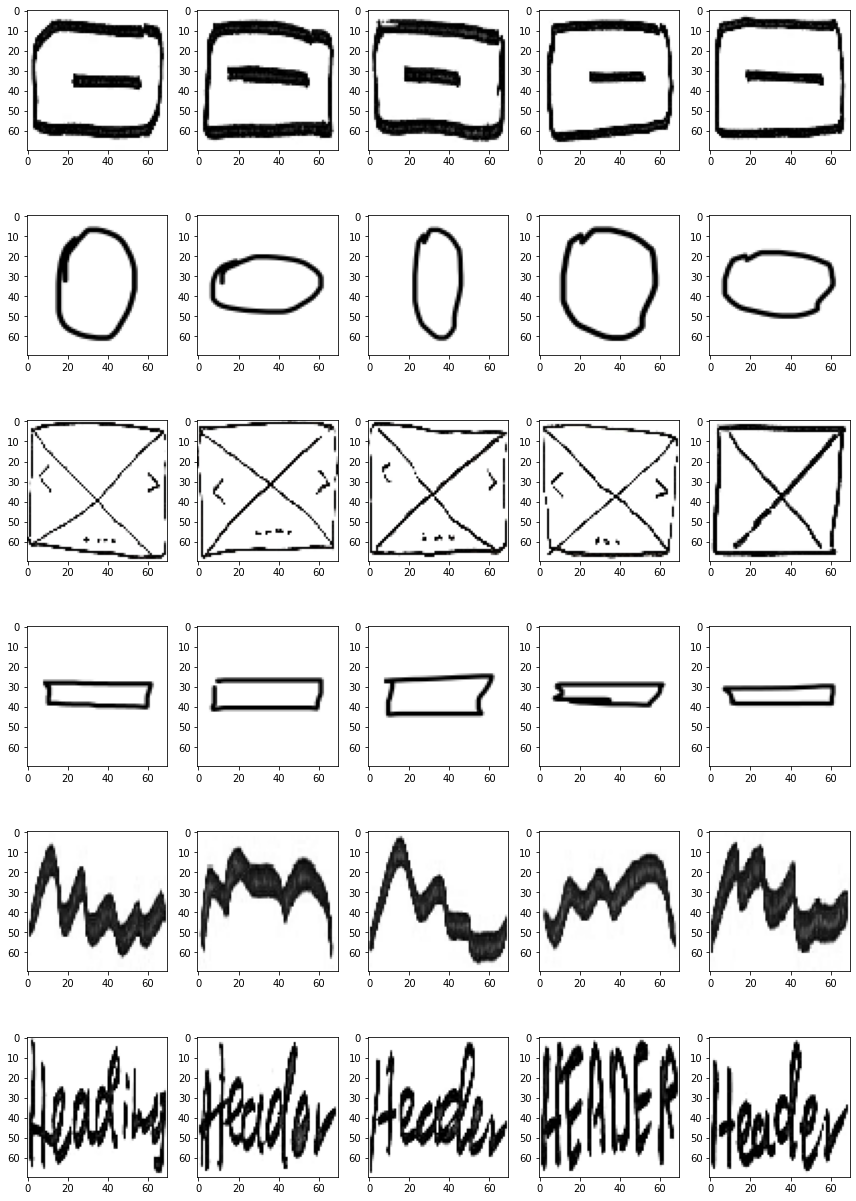

In [2]:
utils.datasets.fer.plot_example_images(plt).show()

In [3]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

38 button images
110 circle images
90 image images
95 input images
45 paragraph images
128 title images


In [4]:
img_size = 70
batch_size = 8

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 506 images belonging to 6 classes.
Found 231 images belonging to 6 classes.


In [5]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(8,(3,3), padding='same', input_shape=(70, 70,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 70, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 70, 70, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 70, 70, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 35, 35, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 128)       2

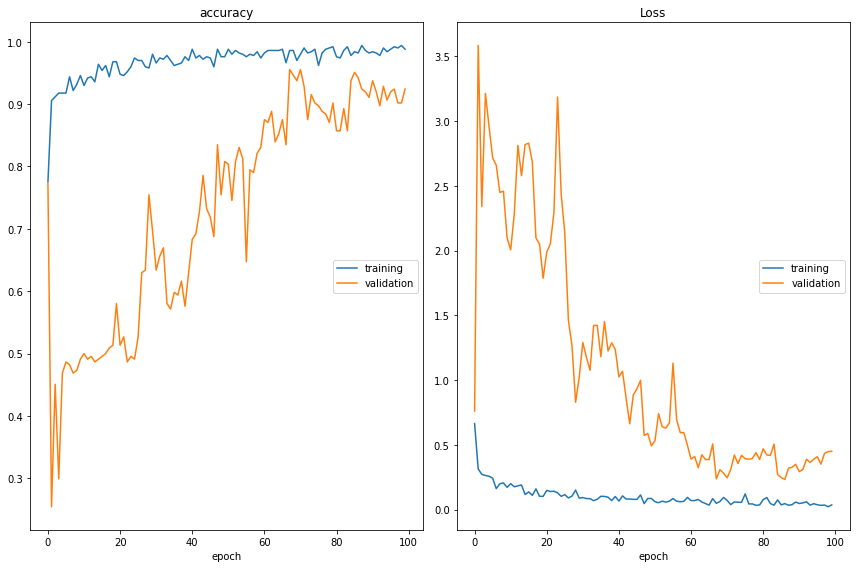

accuracy
	training         	 (min:    0.775, max:    0.994, cur:    0.988)
	validation       	 (min:    0.254, max:    0.955, cur:    0.924)
Loss
	training         	 (min:    0.021, max:    0.663, cur:    0.036)
	validation       	 (min:    0.232, max:    3.583, cur:    0.449)

Epoch 100: saving model to model_weights.h5
63/63 [==============================] - 24s 380ms/step - loss: 0.0357 - accuracy: 0.9880 - val_loss: 0.4491 - val_accuracy: 0.9241 - lr: 1.0000e-04


In [6]:
epochs = 100
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.0001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [7]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)